In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
import numpy as np
from scipy.stats import bernoulli, geom
import seaborn as sns


from setup.setup import retrieve_test_case
from case_edits.ezcase import create_ezcase
from helpers.read_sql import get_sql_results
from setup.data_wrangle2 import create_dataframe_for_case, create_wide_dataframe_for_many_qois
from helpers.variable_interfaces import all_variables as vars

from analysis.plot_subsurfaces import plot_surfaces
from analysis.plot_helpers import plot_zone_domains
from plan.graph_to_subsurfaces import load_attributes

from helpers.helpers import chain_flatten
from experiments.dynamic_door_sched import create_scheds, plot_geom_dist

In [6]:
case = retrieve_test_case("test25_airwall")
case

CaseData(case_name='test', idf=<geomeppy.idf.IDF object at 0x1062cb5b0>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_bol_5'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall'))

In [7]:
case2 = create_ezcase(case.path_to_output, case.path_to_input)

out.idf does not exist


<Axes: >

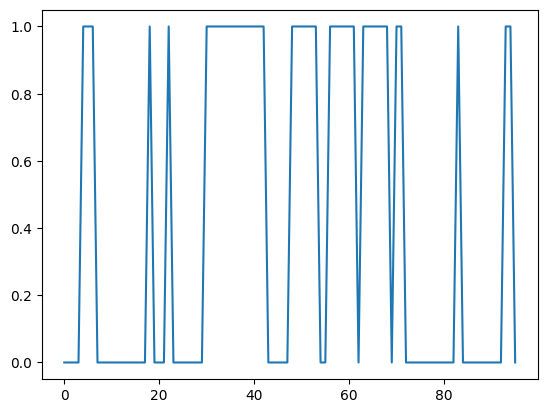

In [63]:
sched2 = create_scheds()
sns.lineplot(sched2)

In [65]:
len(sched2)

96

In [51]:
[1, 2, 3, 4, 5, 6 ,7][1:5]

[2, 3, 4, 5]

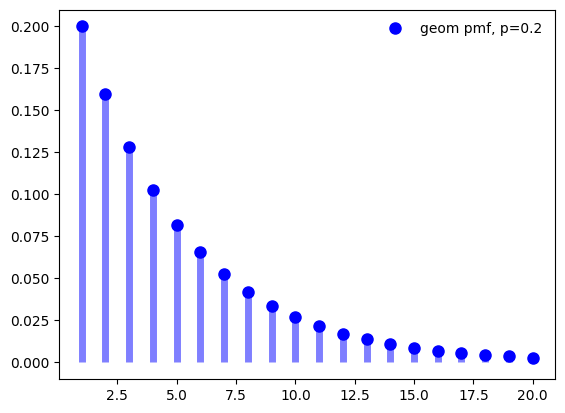

In [40]:
plot_geom_dist(0.2);

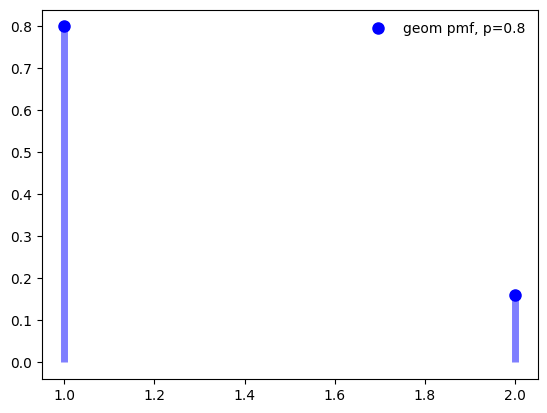

In [16]:
plot_geom_dist(0.8);

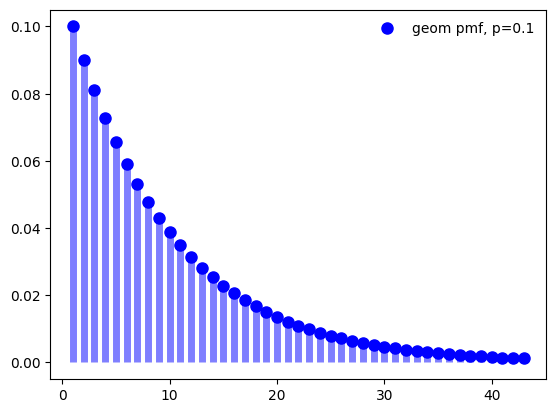

In [15]:
plot_geom_dist(0.1);

In [ ]:
4*24 # number of timesteps.. 

96

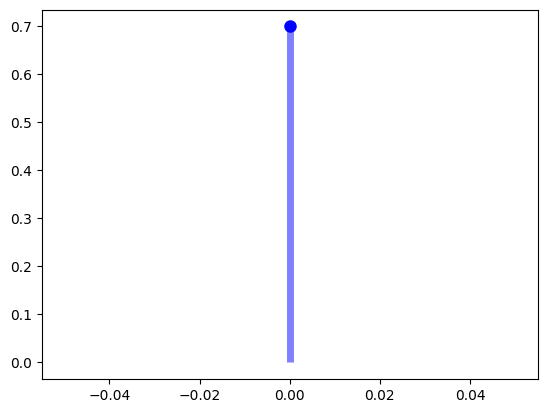

In [73]:
p = 0.3
fig, ax = plt.subplots(1, 1)
x = np.arange(bernoulli.ppf(0.01, p),
              bernoulli.ppf(0.99, p))
ax.plot(x, bernoulli.pmf(x, p), 'bo', ms=8, label='bernoulli pmf')
ax.vlines(x, 0, bernoulli.pmf(x, p), colors='b', lw=5, alpha=0.5)

In [90]:
p_day = 0.6
p_night = 0.3

def generate_day_schedule(p_day=0.6, p_night=0.4):
    r_day = bernoulli.rvs(p_day, size=48).tolist()
    r_night = bernoulli.rvs(p_night, size=48).tolist()
    hours_chunk = 6*4
    return r_night[0:hours_chunk] + r_day + r_night[hours_chunk:]




# print(r_day, r_night)

In [94]:
sched  = generate_day_schedule()

<Axes: >

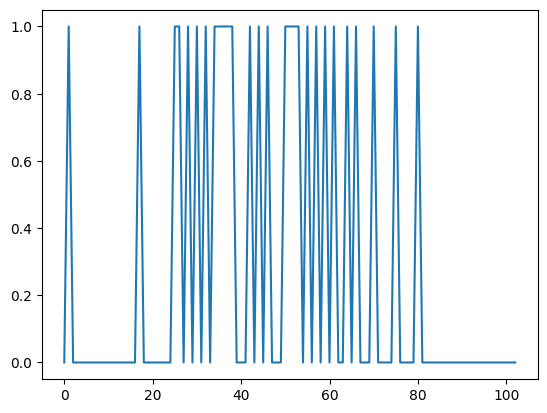

In [210]:
sched2 = create_scheds()
sns.lineplot(sched2)

<Axes: >

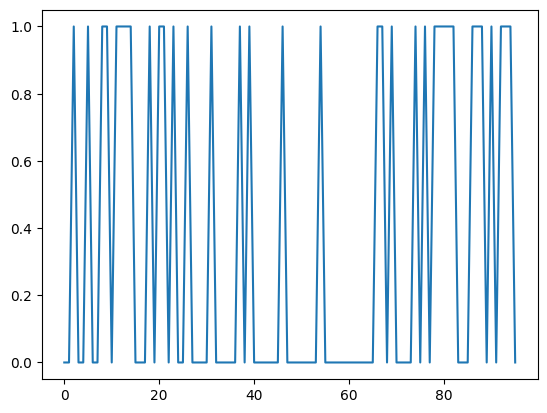

<Axes: >

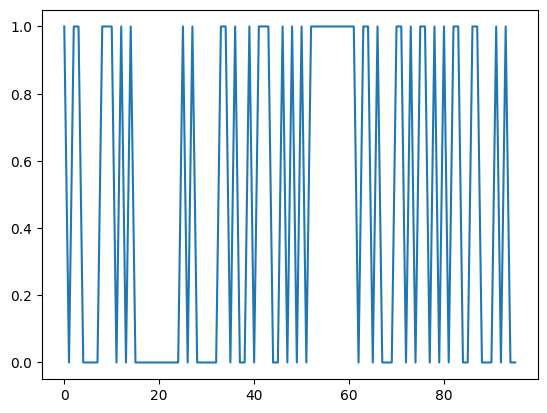

In [95]:
sns.lineplot(sched)

In [87]:
r_day[0:8]

array([0, 1, 1, 1, 0, 0, 1, 0])

In [84]:
8*4

32

In [ ]:
vals = np.arange(48)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [122]:
rv = geom(0.3) # probability of success of indiv trial is 0.5, will maintain 1 pos for maximum of 6 time periods.. 

def generate_intervals(p=0.3):
    rv = geom(p)

    times = []
    time_periods_elapsed = 0

    while time_periods_elapsed < 48:
        val = rv.rvs() 
        times.append(val)
        time_periods_elapsed+=val

    return times


In [173]:
3 % 2

1

In [187]:
def generate_intervals_two_dist(p_closed=0.2, p_open=0.6):
    rv_closed = geom(p_closed)
    rv_open = geom(p_open)

    times = []
    # names = []
    time_periods_elapsed = 0
    ix_tracker = 0

    while time_periods_elapsed < 48:
        is_closed = ix_tracker % 2
        val = rv_closed.rvs() if is_closed else rv_open.rvs()
        # names.append("closed" if is_closed else "open")
        times.append(val)
        time_periods_elapsed+=val
        ix_tracker+=1

    return times


In [186]:
generate_intervals_two_dist(p_closed=0.2, p_open=0.8)

([1, 15, 2, 15, 1, 6, 3, 1, 1, 2, 1],
 ['open',
  'closed',
  'open',
  'closed',
  'open',
  'closed',
  'open',
  'closed',
  'open',
  'closed',
  'open'])

In [146]:
from itertools import tee, zip_longest

[3, 1, 5, 12, 8, 3, 4, 1, 9, 1, 2]

In [149]:
def grouper(iterable, n):
    "Collect data into non-overlapping fixed-length chunks or blocks."
    # grouper('ABCDEFG', 3, incomplete='ignore') → ABC DEF
    iterators = [iter(iterable)] * n
    return list(zip_longest(*iterators, fillvalue=None))


In [151]:
def handle_interv_pair(pair:tuple[int, int | None]):
    a, b = pair
    a_list = [0] * a
    if not b:
        return a_list
    
    b_list = [1]*b
    return a_list + b_list


In [152]:
handle_interv_pair((2,1))

[0, 0, 1]

In [ ]:
intervs = generate_intervals(p=0.3)

paired_intervs = grouper(intervs, 2)
sched = chain_flatten([handle_interv_pair(i) for i in paired_intervs])
# sched


In [98]:
geom.rvs(p=0.6, size=10)

array([1, 3, 1, 3, 2, 1, 1, 2, 5, 3])

In [2]:
fig, ax = plt.subplots(1, 1)

p = 0.1
x = np.arange(geom.ppf(0.01, p),
              geom.ppf(0.99, p))
ax.plot(x, geom.pmf(x, p), 'bo', ms=8, label=f'geom pmf, p={p}')
ax.vlines(x, 0, geom.pmf(x, p), colors='b', lw=5, alpha=0.5)
# rv = geom(p)
# ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
#         label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# case2.run_idf()

idf has changed - running case

/Applications/EnergyPlus-22-2-0/energyplus --weather /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/weather_data/PALO_ALTO/CA_PALO-ALTO-AP_724937_23.EPW --output-directory /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall/results --idd /Applications/EnergyPlus-22-2-0/Energy+.idd /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/base/01example/Minimal_AP_59fc3f.idf

EnergyPlus Starting
EnergyPlus, Version 22.2.0-c249759bad, YMD=2024.11.15 06:39
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/01/2017 for SUMMERDAY
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  0.37sec


EnergyPlus Completed Successfully.


In [21]:
sql = get_sql_results(case.path_to_output)
sql

Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall/results/eplusout.sql

In [22]:
df=create_dataframe_for_case(case, vars.afn.surface["opening_factor"])
df.head()

case_names,space_names,datetimes,AFN Surface Venting Window or Door Opening Factor [fraction]
str,str,datetime[μs],f64
"""test""","""BLOCK 05 STOREY 0 WALL 0004 WI…",2017-07-01 00:00:00,1.0
"""test""","""BLOCK 05 STOREY 0 WALL 0004 WI…",2017-07-01 00:15:00,1.0
"""test""","""BLOCK 05 STOREY 0 WALL 0004 WI…",2017-07-01 00:30:00,1.0
"""test""","""BLOCK 05 STOREY 0 WALL 0004 WI…",2017-07-01 00:45:00,1.0
"""test""","""BLOCK 05 STOREY 0 WALL 0004 WI…",2017-07-01 01:00:00,1.0


In [24]:
df["AFN Surface Venting Window or Door Opening Factor [fraction]"].unique().to_list()

[0.0, 0.9999999999999999, 1.0]

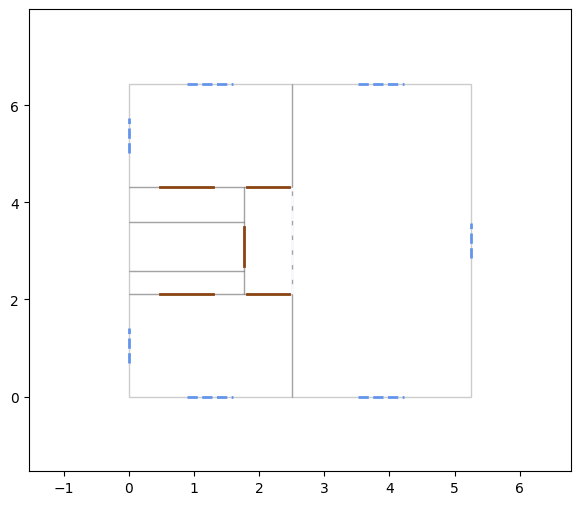

In [26]:
time = datetime(2017, 7, 1, 12, 0)
fig, ax = plt.subplots(nrows=1, figsize=(7, 6))
ax = plot_zone_domains(case.idf, ax)
ax, data = plot_surfaces(case, time, ax)